# Advanced features in Rasterio

https://gist.github.com/sgillies/7e5cd548110a5b4d45ac1a1d93cb17a3

[Rasterio](https://mapbox.github.io/rasterio/) is an open source Python package that wraps [GDAL](http://www.gdal.org/) in idiomatic Python functions and classes.

The last pre-release of Rasterio has five advanced features that are useful for developing cloud-native applications.

1. Quick overviews of GeoTIFFs in the cloud
2. Quick subsets of GeoTIFFs in the cloud
3. Lazy warping of GeoTIFFs in the cloud
4. Formatted files in RAM
5. Datasets in zipped streams

Please note these features already exist in the latest version of the GDAL library. What Rasterio does, for the first time, is make them into solid Python patterns.

This notebook is a demonstration of these patterns.

## Notebook requirements

This notebook uses f-strings and requires Python 3.6. It will probably work with other Python 3 versions if the f-strings are replaced by `str.format()` calls. My team has switched to Python 3.6 this year and we're glad we did.

I recommend that you run this notebook in an isolated Python environment. My preference is for one created with venv. Install the latest pre-release of Rasterio with its S3-related extras.

```
python3.6 -m venv rasterio-advanced-features
source rasterio-advanced-features/bin/activate
(rasterio-advanced-features) $ pip install --pre rasterio[s3]
(rasterio-advanced-features) $ pip install mercantile jupyter
```

If you're a conda user, do the following.

```
conda create -n rasterio-advanced-features python=3.6 boto3 jupyter
conda install -c conda-forge mercantile
conda install -c conda-forge/label/dev rasterio
```

You will need an AWS account and credentials to run the scripts in this notebook. An AWS account is free and doesn't take long to set up: https://aws.amazon.com/account/.

## Rasterio documentation

This notebook glosses over basic usage of Rasterio and discusses several advanced usage patterns. Please consult the documentation of the Rasterio package for help with basic usage: https://mapbox.github.io/rasterio/.

## Quick tour of the AWS Landsat PDS

We're going to use the [AWS Landsat PDS](https://aws.amazon.com/public-datasets/landsat/) as a source of data for this notebook. From the site:

> Landsat 8 data is available for anyone to use via Amazon S3. All Landsat 8 scenes are available from the start of imagery capture. All new Landsat 8 scenes are made available each day, often within hours of production.

> The Landsat program is a joint effort of the U.S. Geological Survey and NASA. First launched in 1972, the Landsat series of satellites has produced the longest, continuous record of Earth’s land surface as seen from space. NASA is in charge of developing remote-sensing instruments and spacecraft, launching the satellites, and validating their performance. USGS develops the associated ground systems, then takes ownership and operates the satellites, as well as managing data reception, archiving, and distribution. Since late 2008, Landsat data have been made available to all users free of charge. Carefully calibrated Landsat imagery provides the U.S. and the world with a long-term, consistent inventory of vitally important global resources.
AWS has made Landsat 8 data freely available on Amazon S3 so that anyone can use our on-demand computing resources to perform analysis and create new products without needing to worry about the cost of storing Landsat data or the time required to download it.

> Landsat data is in AWS S3 bucket named *landsat-pds* and is organzied by *path*, *row*, and *scene*. The scene id also has the path and row encoded in it. If you know the scene you're interested in – by searching the USGS Earth Explorer site, or via James Bridle's [Landsat Tumblr](http://laaaaaaandsat.tumblr.com/) – you can extract the path and row and construct an AWS S3 prefix that lets you find all the objects associated with that scene using boto3.

If you don't have AWS credentials set in your environment, you can set them in the block below. If you, delete the block. Be careful to remove your credentials from the notebook before sharing it with anyone else.

In [2]:
%env AWS_ACCESS_KEY_ID= AWS_SECRET_ACCESS_KEY=

env: AWS_ACCESS_KEY_ID=AWS_SECRET_ACCESS_KEY=


In the script below we will use the AWS boto3 module to examine the structure of the Landsat Public Dataset. `LC08_L1TP_139045_20170304_20170316_01_T1` is a Landsat scene ID with a standard pattern.

In [2]:
import re

scene = 'LC08_L1TP_139045_20170304_20170316_01_T1'
path, row = re.match(r'LC08_L1TP_(\d{3})(\d{3})', scene).groups()
prefix = f'c1/L8/{path}/{row}/{scene}'

import boto3

for objsum in boto3.resource('s3').Bucket('landsat-pds').objects.filter(Prefix=prefix):
    print(objsum.bucket_name, objsum.key, objsum.size)

landsat-pds c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_ANG.txt 117122
landsat-pds c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B1.TIF 50091654
landsat-pds c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B1.TIF.ovr 6454401
landsat-pds c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B10.TIF 48758134
landsat-pds c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B10.TIF.ovr 7379918
landsat-pds c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B10_wrk.IMD 11597
landsat-pds c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B11.TIF 46753150
landsat-pds c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B11.TIF.ovr 72

## There's a web browser in GDAL

Each of the .TIF files in the landsat-pds bucket is a georeferenced raster dataset formatted as a [cloud optimized GeoTIFF](https://trac.osgeo.org/gdal/wiki/CloudOptimizedGeoTIFF). A GeoTIFF is a TIFF with extra tags specifying spatial reference systems and coordinates and can be accompanied by reduced-resolution .ovr files as well as other auxiliary files.

There is a browser in the latest version of GDAL that can navigate these TIFFs and auxiliary files like a web browser navigates linked HTML documents. HTTP and the GeoTIFF format replace specialized geospatial raster services like [WCS](http://www.opengeospatial.org/standards/wcs) in the workflow presented in this notebook.

By using GDAL's browser, Rasterio can open and query cloud-optimized GeoTIFFs *without* prior download.

## Quick overviews of GeoTIFFs

Rasterio affords us quickly-generated overviews of Landsat PDS GeoTIFFs. In the script below we will open a GeoTIFF stored on S3 (and identified by an AWS CLI style 's3://' URI), read a 10:1 overview of its data as a Numpy ndarray, and display the array. Note that we use no temporary file to do so.

The S3 object with the name ending in `B4.TIF` corresponds to the red band of the Landsat imager.

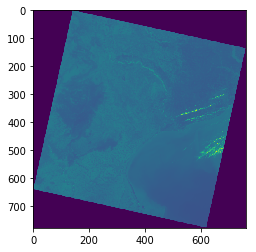

In [3]:
import rasterio

with rasterio.open(f's3://landsat-pds/{prefix}/{scene}_B4.TIF') as src:
    arr = src.read(out_shape=(src.height//10, src.width//10))

%matplotlib inline

from matplotlib import pyplot as plt

plt.imshow(arr[0])
plt.show()

## A look backstage

Not only is there a web browser in a Rasterio dataset object, it's a sophisticated web brower that uses HTTP range requests to download the least number of bytes required to execute `src.read()` with the given parameters. With a little extra configuration we can see exactly how few bytes.

We will read and display a 10:1 overview as we did for band 4. The S3 object in the listing above with the name ending in `B5.TIF` corresponds to the near-infrared (NIR) band of the Landsat imager.

The little extra configuration needed is to use a rasterio environment with `CPL_CURL_VERBOSE=True` as the context for opening and reading a Landsat PDS GeoTIFF.

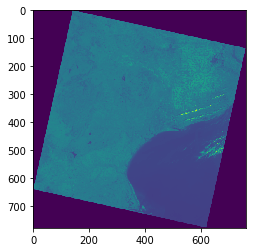

In [4]:
with rasterio.Env(CPL_CURL_VERBOSE=True):
    with rasterio.open(f's3://landsat-pds/{prefix}/{scene}_B5.TIF') as src:
        arr = src.read(out_shape=(src.height//10, src.width//10))

plt.imshow(arr[0])
plt.show()

Within a `rasterio.Env` context with `CPL_CURL_VERBOSE=True`, the GDAL functions called by `rasterio.open()` and `src.read()` will print HTTP request and response details as you would see if you used `curl -v`.

A dissected transcript follows. In the transcript, we can see that 5 HTTP requests are made to display the 10:1 overview image of band 5.

First we see the request GDAL makes for only the first 16384 (2^14) bytes of the 63 MB B5.TIF GeoTIFF file.
Please note: I've removed sensitive headers from the transcript. Yours will be different.

```
* Couldn't find host landsat-pds.s3.amazonaws.com in the .netrc file; using defaults
* Connection 1 seems to be dead!
* Closing connection 1
*   Trying 52.218.160.34...
* TCP_NODELAY set
* Connected to landsat-pds.s3.amazonaws.com (52.218.160.34) port 443 (#2)
* SSL re-using session ID
* TLS 1.2 connection using TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256
* Server certificate: *.s3.amazonaws.com
* Server certificate: DigiCert Baltimore CA-2 G2
* Server certificate: Baltimore CyberTrust Root
> GET /c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B5.TIF HTTP/1.1
Host: landsat-pds.s3.amazonaws.com
Range: bytes=0-16383
Accept: */*

< HTTP/1.1 206 Partial Content
< Date: Thu, 07 Dec 2017 17:02:07 GMT
< Last-Modified: Sat, 29 Apr 2017 11:24:24 GMT
< ETag: "8dfaba5cd40136c31959b411038760ab"
< Accept-Ranges: bytes
< Content-Range: bytes 0-16383/63037553
< Content-Type: image/tiff
< Content-Length: 16384
< Server: AmazonS3
<
* Connection #2 to host landsat-pds.s3.amazonaws.com left intact
```

At this point you could get the `profile` attribute of the dataset object we've named `src` and GDAL wouldn't need to download any more bytes to provide the dataset metadata. Thanks to the the TIFF format's consolidation of metadata in the head of the file and [HTTP range requests](https://tools.ietf.org/html/rfc7233), we only need to read 0.03% of the file to know its dimensions, data type, spatial extent, and coordinate reference system.

Calling `src.read()` triggers 3 more HTTP requests by GDAL. The third is for the first 16384 (2^14) bytes of the 8 MB .ovr file that GDAL discovered when it fetched the directory listing. In our case, the array returned by ``src.read()`` will come entirely from the .ovr file. For a reference on GeoTIFF overviews, see http://www.gdal.org/frmt_gtiff.html.

```
* Couldn't find host landsat-pds.s3.amazonaws.com in the .netrc file; using defaults
* Found bundle for host landsat-pds.s3.amazonaws.com: 0x109a5a9a0 [can pipeline]
* Re-using existing connection! (#2) with host landsat-pds.s3.amazonaws.com
* Connected to landsat-pds.s3.amazonaws.com (52.218.160.34) port 443 (#2)
> GET /c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B5.TIF.ovr HTTP/1.1
Host: landsat-pds.s3.amazonaws.com
Range: bytes=0-16383
Accept: */*

< HTTP/1.1 206 Partial Content
< Date: Thu, 07 Dec 2017 17:02:07 GMT
< Last-Modified: Sat, 29 Apr 2017 11:23:56 GMT
< ETag: "d6777167ccd6141537b5e9d71abdcfeb"
< Accept-Ranges: bytes
< Content-Range: bytes 0-16383/8033890
< Content-Type: application/octet-stream
< Content-Length: 16384
< Server: AmazonS3
<
* Connection #2 to host landsat-pds.s3.amazonaws.com left intact
```

The fourth and fifth requests are for overview imagery stored near the tail of the .ovr file, as you can see in the request and response `Content-Range` headers.

```
* Couldn't find host landsat-pds.s3.amazonaws.com in the .netrc file; using defaults
* Found bundle for host landsat-pds.s3.amazonaws.com: 0x109a5a9a0 [can pipeline]
* Re-using existing connection! (#2) with host landsat-pds.s3.amazonaws.com
* Connected to landsat-pds.s3.amazonaws.com (52.218.160.34) port 443 (#2)
> GET /c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B5.TIF.ovr HTTP/1.1
Host: landsat-pds.s3.amazonaws.com
Range: bytes=7110656-7438335
Accept: */*

< HTTP/1.1 206 Partial Content
< Date: Thu, 07 Dec 2017 17:02:07 GMT
< Last-Modified: Sat, 29 Apr 2017 11:23:56 GMT
< ETag: "d6777167ccd6141537b5e9d71abdcfeb"
< Accept-Ranges: bytes
< Content-Range: bytes 7110656-7438335/8033890
< Content-Type: application/octet-stream
< Content-Length: 327680
< Server: AmazonS3
<
* Connection #2 to host landsat-pds.s3.amazonaws.com left intact
* Couldn't find host landsat-pds.s3.amazonaws.com in the .netrc file; using defaults
* Found bundle for host landsat-pds.s3.amazonaws.com: 0x109a5a9a0 [can pipeline]
* Re-using existing connection! (#2) with host landsat-pds.s3.amazonaws.com
* Connected to landsat-pds.s3.amazonaws.com (52.218.160.34) port 443 (#2)
> GET /c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B5.TIF.ovr HTTP/1.1
Host: landsat-pds.s3.amazonaws.com
Range: bytes=7438336-8033889
Accept: */*

< HTTP/1.1 206 Partial Content
< Date: Thu, 07 Dec 2017 17:02:07 GMT
< Last-Modified: Sat, 29 Apr 2017 11:23:56 GMT
< ETag: "d6777167ccd6141537b5e9d71abdcfeb"
< Accept-Ranges: bytes
< Content-Range: bytes 7438336-8033889/8033890
< Content-Type: application/octet-stream
< Content-Length: 595554
< Server: AmazonS3
<
* Connection #2 to host landsat-pds.s3.amazonaws.com left intact
```

We got a 10:1 overview of one band of one Landsat scene and downloaded only 1/9th of its .ovr file – which is itself only about 1/8th of the target file.

## Quick subsets of GeoTIFFs

Having seen how GeoTIFF overviews work in the cloud, let's look at access to full resolution subsets of imagery.

Here we'll read imagery from a random block of the GeoTIFF. Please note that blocks near the south and east edges of the GeoTIFF may be smaller than 512 x 512 pixels.

(5, 7) Window(col_off=3584, row_off=2560, width=512, height=512)


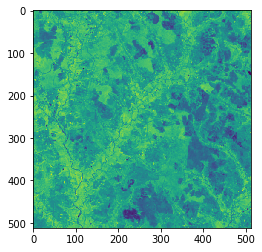

In [5]:
import random

with rasterio.Env(CPL_CURL_VERBOSE=True):
    with rasterio.open(f's3://landsat-pds/{prefix}/{scene}_B5.TIF') as src:
        ij, window = random.choice(list(src.block_windows()))
        print(ij, window)
        arr = src.read(window=window)

plt.imshow(arr[0])
plt.show()

## Backstage again

Here is the transcript.

```
* Hostname landsat-pds.s3.amazonaws.com was found in DNS cache
*   Trying 52.218.208.122...
* TCP_NODELAY set
* Connected to landsat-pds.s3.amazonaws.com (52.218.208.122) port 443 (#5)
* SSL re-using session ID
* TLS 1.2 connection using TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256
* Server certificate: *.s3.amazonaws.com
* Server certificate: DigiCert Baltimore CA-2 G2
* Server certificate: Baltimore CyberTrust Root
> GET /c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B5.TIF HTTP/1.1
Host: landsat-pds.s3.amazonaws.com
Range: bytes=44646400-44957695
Accept: */*

< HTTP/1.1 206 Partial Content
< Date: Thu, 07 Dec 2017 18:17:20 GMT
< Last-Modified: Sat, 29 Apr 2017 11:24:24 GMT
< ETag: "8dfaba5cd40136c31959b411038760ab"
< Accept-Ranges: bytes
< Content-Range: bytes 44646400-44957695/63037553
< Content-Type: image/tiff
< Content-Length: 311296
< Server: AmazonS3
<
* Connection #5 to host landsat-pds.s3.amazonaws.com left intact
```

We've downloaded only 311 KB (every block of the GeoTIFF is DEFLATE compressed) of a 63 MB file to get that piece of data.

GDAL's GeoTIFF browser caches the data in the fetched byte ranges, so you may not see any curl transcripts from subsequent requests. Finer control of caching will be a feature of GDAL 2.3 and future version of Rasterio.

## Lazy warping: WarpedVRT

The Landsat PDS data is georeferenced using the [Universal Transverse Mercator (UTM) system](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system). To use it in another system such as Web Mercator (also known as 'epsg:3857', as in Google Maps, Mapbox, etc.) it must be reprojected or *warped*.

Rasterio has an abstraction for reprojection that also does not require prior download of the GeoTIFF file and, as with the previously discussed patterns, fetches the least number of bytes required to fill the reading window.

In the script below we fetch imagery from the B5.TIF (georeferenced to UTM Zone 45) that intersects with the zoom level 11 Web Mercator tile at the center of the GeoTIFF. We will use functions from the mercantile module to get the bounds of the that tile.

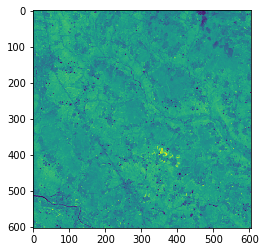

In [6]:
import mercantile

from rasterio.vrt import WarpedVRT

with rasterio.open(f's3://landsat-pds/{prefix}/{scene}_B5.TIF') as src:

    lng, lat = src.lnglat()
    tile = mercantile.tile(lng, lat, 11)
    merc_bounds = mercantile.xy_bounds(tile)

    with WarpedVRT(src, dst_crs='epsg:3857') as vrt:

        window = vrt.window(*merc_bounds)
        arr_transform = vrt.window_transform(window)
        arr = vrt.read(window=window)

plt.imshow(arr[0])
plt.show()

## Formatted files in RAM: MemoryFile

Raster data processing often involves temporary files. For example, in making a set of Web Mercator tiles from a differently projected raster dataset we may use a temporary GeoTIFF dataset to hold the result of a warp operation and then transform this into a JPEG, PNG, or WebP for use on the web.

Python has a `NamedTemporaryFile` class in its `tempfile` module that is well suited for this task. It has a visible name in the filesystem, which GDAL requires, and is automatically cleaned up when no longer used. Its usage a raster-processing program is something like we see in the script below.

In [7]:
from tempfile import NamedTemporaryFile

count, height, width = arr.shape
dtype = arr.dtype

with NamedTemporaryFile() as temp:
    with rasterio.open(temp.name, 'w', driver='GTiff', dtype=dtype,
                       count=count, height=height, width=width,
                       transform=arr_transform) as dst:
        dst.write(arr)

    temp_bytes = temp.read()

We can see an indicator that we have a TIFF file in `temp` if we print the first few bytes.

In [8]:
print(temp_bytes[:20])

b'II*\x00\x08\x00\x00\x00\r\x00\x00\x01\x03\x00\x01\x00\x00\x00\\\x02'


Let’s say you want to write a program like this that will run on a computer with a very limited filesystem or no filesystem at all. Python has an in-memory binary file-like class, `io.BytesIO`, but, unlike `NamedTemporaryFile`, instances of `BytesIO` lack the name GDAL needs to access data. To solve this problem, Rasterio provides a new class, `io.MemoryFile`, a drop-in replacement for Python’s `NamedTemporaryFile` which keeps its bytes in a virtual file in an in-memory filesystem that GDAL can access, not on disk.

The usage of `MemoryFile` is modeled after Python’s `zipfile.ZipFile` class. `MemoryFile.open` returns a dataset object, just as `rasterio.open` does.

In [9]:
from rasterio.io import MemoryFile

with MemoryFile() as temp:
    with temp.open(driver='GTiff', dtype=dtype,
                   count=count, height=height, width=width,
                   transform=arr_transform) as dst:
        dst.write(arr)
    png_bytes = temp.read()

print(temp_bytes[:20])

b'II*\x00\x08\x00\x00\x00\r\x00\x00\x01\x03\x00\x01\x00\x00\x00\\\x02'


A `MemoryFile` can also be used to access datasets contained in a stream of bytes.

In [10]:
with MemoryFile(temp_bytes) as temp:
    with temp.open() as src:
        print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 604, 'height': 604, 'count': 1, 'crs': None, 'transform': Affine(32.374971311808814, 0.0, 9666532.345057327,
       0.0, -32.374971311808814, 2485120.663606849), 'tiled': False, 'interleave': 'band'}


Below is an example of downloading an entire Landsat PDS GeoTIFF to a stream of bytes and then opening the stream of bytes.

In [13]:
from io import BytesIO

f's3://landsat-pds/{prefix}/{scene}_B4.TIF'

s3 = boto3.resource('s3')
bucket = s3.Bucket('landsat-pds')
obj = bucket.Object(f'{prefix}/{scene}_B4.TIF')

with BytesIO() as temp:
    obj.download_fileobj(temp)
    
    temp.seek(0)
    with MemoryFile(temp) as memfile:
        with memfile.open() as src:
            print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7611, 'height': 7771, 'count': 1, 'crs': CRS({'init': 'epsg:32645'}), 'transform': Affine(30.0, 0.0, 382185.0,
       0.0, -30.0, 2512515.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


## Zip files in memory

Rasterio can read datasets within zipped streams of bytes. Zipfiles are commonly used in the GIS domain to package legacy multi-file formats like shapefiles (a shapefile is actually an ensemble of .shp, .dbf, .shx, .prj, and other files) or virtual raster files (VRT) and the rasters they reference.

Below we'll fetch a VRT and JPEG pair from the Rasterio GitHub repo and package them in an in-memory zip file to simulate a zip file such as one that a server might accept as an upload.

In [14]:
import io
import zipfile

import requests

temp = io.BytesIO()

with zipfile.ZipFile(temp, 'w') as pkg:
    res = requests.get('https://raw.githubusercontent.com/mapbox/rasterio/master/tests/data/389225main_sw_1965_1024.jpg')
    pkg.writestr('389225main_sw_1965_1024.jpg', res.content)
    res = requests.get('https://raw.githubusercontent.com/mapbox/rasterio/master/tests/data/white-gemini-iv.vrt')
    pkg.writestr('white-gemini-iv.vrt', res.content)

We then read the zipped VRT file. You must rewind the `BytesIO` file because its current position has been left at its end.

/Users/sean/envs/rio-blog-post/lib/python3.6/site-packages/rasterio/io.py:157: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  return DatasetReader(vsi_path, driver=driver, **kwargs)


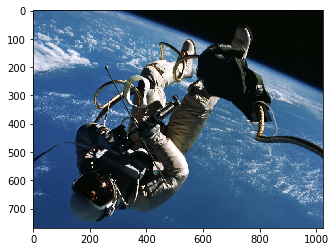

In [15]:
from rasterio.io import ZipMemoryFile

temp.seek(0)
with ZipMemoryFile(temp) as zipmemfile:
    with zipmemfile.open('white-gemini-iv.vrt') as src:
        rgb = src.read()

import numpy

plt.imshow(numpy.rollaxis(rgb, 0, 3))
plt.show()

Using code like that above, you can build web services that accept zipped shapefiles or zipped VRT and rasters and process them without extracting them to your filesystem.

## Conclusion

Rasterio turns 5 GDAL features into solid, idiomatic Python patterns suited for building applications that run in the cloud.

1. Quick overviews of GeoTIFFs in the cloud
2. Quick subsets of GeoTIFFs in the cloud
3. Lazy warping of GeoTIFFs in the cloud
4. Formatted files in RAM
5. Datasets in zipped streams

## Acknowledgements

GDAL's [virtual file systems](http://www.gdal.org/gdal_virtual_file_systems.html), upon which Rasterio's `MemoryFile` and `ZipMemoryFile` are based, and virtually warped dataset feature, used by `WarpedVRT`, were written by Frank Warmerdam.

Even Rouault is the author of GDAL's curl-based HTTP virtual filesystem and the GeoTIFF "browser" that powers cloud-optimized GeoTIFFs in Rasterio. Mapbox is proud to be a sponsor of early work on GDAL's browser.

Rasterio's binary wheels are made possible by the tools and wisdom of the Python wheel-builders community: https://mail.python.org/mailman/listinfo/wheel-builders. Matthew Brett's [delocate](https://github.com/matthew-brett/delocate) has been particularly useful.

Rasterio is written by programmers at companies and organizations such as Mapbox, the Conservation Biology Institute, Planet, the U.S. Geological Survey, Continuum Analytics, and DigitalGlobe. See https://github.com/mapbox/rasterio/graphs/contributors for the complete list of contributors.